In [1]:
# import * from Img_processing
# File and System Operations
import os
import glob
import random
import shutil
import re

# Numerical and Data Manipulation
import numpy as np
import pandas as pd

# Image Processing
from skimage import io
from PIL import Image
import cv2 as cv

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning and Preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    silhouette_score, silhouette_samples, rand_score,
    classification_report, confusion_matrix, pairwise_distances_argmin_min
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

# Utilities
from tqdm.notebook import tqdm
from scipy.spatial.distance import cosine

C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
# %%capture

# # @title Importação das imagens
# !gdown 1r0a3Pf540L_n8j9ezQjY0ewUgf2s3WgX
# !unzip '/content/Fungi.zip'

In [3]:
def images_list(path):
    full_path = []
    images = os.listdir(path)
    for i in images:
        full_path.append(os.path.join(path, i))
    return full_path

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def show_class_examples(df_imgs, num_classes, examples_per_class):
    """
    Display examples of images from each class.

    Parameters:
        df_imgs (pd.DataFrame): DataFrame containing image paths and labels. Must have 'path' and 'y' columns.
        num_classes (int): Number of classes to display.
        examples_per_class (int): Number of examples to display per class.
    """
    # Create a grid for the images
    fig, axes = plt.subplots(examples_per_class, num_classes, figsize=(num_classes * 2, examples_per_class * 2))
    axes = axes.flatten()

    # Iterate through each class and sample images
    for class_idx in range(num_classes):
        # Filter DataFrame for the current class
        class_images = df_imgs[df_imgs['y'] == class_idx]
        
        # Check if the class has enough images
        if len(class_images) < examples_per_class:
            raise ValueError(f"Not enough examples in class {class_idx}. Required: {examples_per_class}, Found: {len(class_images)}")
        
        # Randomly sample the required number of examples from this class
        sampled_idx = np.random.choice(class_images.index, size=examples_per_class, replace=False)
        
        for row, img_idx in enumerate(sampled_idx):
            # Compute the correct position in the grid
            ax = axes[row * num_classes + class_idx]
            
            # Load and display the image
            full_path = class_images.loc[img_idx, 'path']
            ax.imshow(plt.imread(full_path))
            ax.set_title(f"Class {class_idx}")
            ax.set_axis_off()

    # Adjust layout for better display
    plt.tight_layout()
    plt.show()

In [5]:
def stratified_split(df, label_col, train_size=0.7, val_size=0.15, test_size=0.15, random_state=None):
    """
    Perform a stratified train-validation-test split.

    Parameters:
        df (pd.DataFrame): DataFrame containing the data to split.
        label_col (str): Name of the column containing the labels.
        train_size (float): Proportion of the data to include in the train set.
        val_size (float): Proportion of the data to include in the validation set.
        test_size (float): Proportion of the data to include in the test set.
        random_state (int, optional): Random seed for reproducibility.

    Returns:
        tuple: Three DataFrames corresponding to the train, validation, and test sets.
    """
    if not np.isclose(train_size + val_size + test_size, 1.0):
        raise ValueError("Train, validation, and test sizes must sum to 1.0")

    # First split into train+val and test
    train_val_df, test_df = train_test_split(
        df, test_size=test_size, stratify=df[label_col], random_state=random_state
    )

    # Adjust validation size proportion relative to train+val
    val_relative_size = val_size / (train_size + val_size)

    # Split train+val into train and validation
    train_df, val_df = train_test_split(
        train_val_df, test_size=val_relative_size, stratify=train_val_df[label_col], random_state=random_state
    )
    
    print(f"{'Training Set Shape:':<30}{train_df.shape}")
    print(f"{'Validation Set Shape:':<30}{val_df.shape}")
    print(f"{'Test Set Shape:':<30}{test_df.shape}")


    return train_df, val_df, test_df

In [6]:
def stratified_sample_with_split(df, label_col, sample_size, random_state=None):
    """
    Stratified sampling from a DataFrame using train_test_split.

    Parameters:
        df (pd.DataFrame): DataFrame containing the data to sample from.
        label_col (str): Name of the column containing the labels.
        sample_size (int): Total number of samples to retrieve.
        random_state (int, optional): Random seed for reproducibility.

    Returns:
        pd.DataFrame: A stratified sampled subset of the original DataFrame.
    """
    # Check if sample size exceeds the dataset size
    if sample_size > len(df):
        raise ValueError(f"Sample size {sample_size} exceeds the total number of rows in the dataset ({len(df)}).")
    
    # Calculate the test_size as the proportion of data not included in the sample
    test_size = 1 - sample_size / len(df)
    
    # Use train_test_split to create the stratified sample
    sampled_df, _ = train_test_split(
        df,
        test_size=test_size,
        stratify=df[label_col],
        random_state=random_state
    )
    
    return sampled_df

# Processamento inicial

In [7]:
# look-up table
imgs_classes = {0:'H1', 1 : 'H2', 2 : 'H3', 3 : 'H5', 4 : 'H6'}

paths = []
for label, path_id in imgs_classes.items():
    aux_class = pd.DataFrame({"path" : np.array(images_list('content/' + path_id)) , "y": label })
    paths.append(aux_class)

df_imgs = pd.concat(paths, ignore_index = True)
df_imgs.head()

,path,y
0,content/H1\H1_100a_1.jpg,0
1,content/H1\H1_100a_2.jpg,0
2,content/H1\H1_100a_3.jpg,0
3,content/H1\H1_100a_4.jpg,0
4,content/H1\H1_100a_5.jpg,0


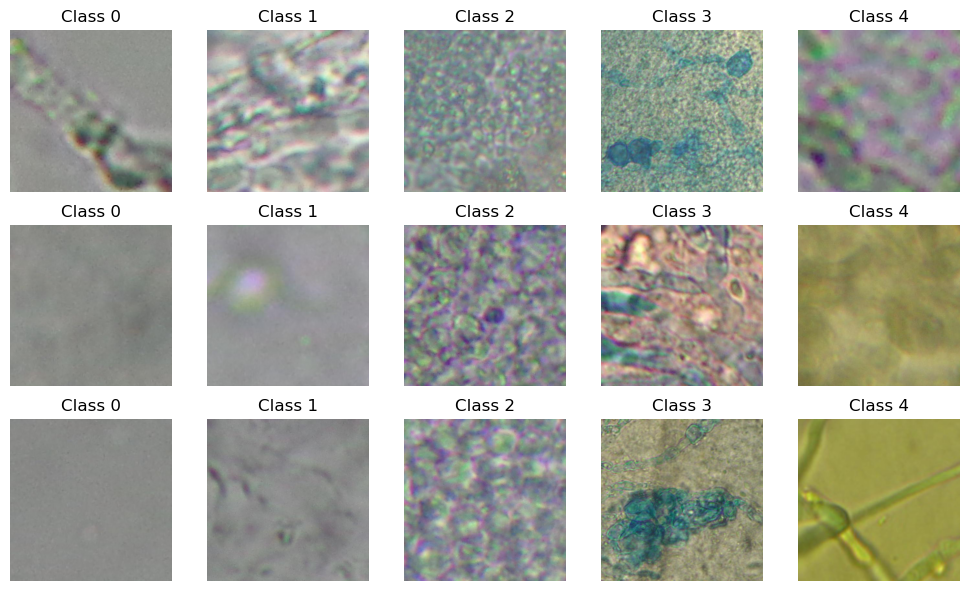

In [8]:
show_class_examples(df_imgs=df_imgs, num_classes=5, examples_per_class=3)

In [13]:
# @title Treino-Validação-Teste split
train_df, val_df, test_df = stratified_split(df_imgs, label_col='y', train_size=0.6, val_size=0.15, test_size=0.25, random_state=42)

train_df.head()

Training Set Shape:           (5468, 2)
Validation Set Shape:         (1367, 2)
Test Set Shape:               (2279, 2)


,path,y
3568,content/H1\H1_7b_8.jpg,0
2183,content/H1\H1_51c_14.jpg,0
6972,content/H3\H3_18b_8.jpg,2
405,content/H1\H1_10a_6.jpg,0
3560,content/H1\H1_7b_11.jpg,0


In [14]:
train_df['y'].value_counts()

y
0    2643
1    1400
2     491
3     491
4     443
Name: count, dtype: int64

In [15]:
# @title Amostragem treino - opcional
sampled_train_df = stratified_sample_with_split(df = train_df, label_col='y', sample_size=500, random_state=42)

paths = sampled_train_df['path'].tolist()
dataset_sample = []
for img_path in paths:
  try:
      image = io.imread(img_path)
      image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
      dataset_sample.append(image)
  except Exception as e:
      print('Warning:', img_path, e)

sampled_train_df.head()

,path,y
1245,content/H1\H1_22d_19.jpg,0
2866,content/H1\H1_67a_25.jpg,0
1405,content/H1\H1_28a_2.jpg,0
5678,content/H2\H2_4a_12.jpg,1
910,content/H1\H1_16b_20.jpg,0


In [16]:
sampled_train_df['y'].value_counts()

y
0    242
1    128
3     45
2     45
4     40
Name: count, dtype: int64

In [17]:
# @title Função features baixo nível

def compute_color_hists(dataset):   
    # Initialize lists to store histograms for each color channel and grayscale
    dataset_hist_r = []
    dataset_hist_g = []
    dataset_hist_b = []
    
    # Colors for channel histograms
    color_channels = ('b', 'g', 'r')
    
    # Calculate and normalize histograms for each image in the dataset
    for image in dataset:
      # Color histograms
      for i, col in enumerate(color_channels):
          histr = cv.calcHist([image], [i], None, [256], [0, 256])
          histr = histr / np.linalg.norm(histr)  # Normalize the histogram
          if col == 'r':
              dataset_hist_r.append(histr)
          elif col == 'g':
              dataset_hist_g.append(histr)
          elif col == 'b':
              dataset_hist_b.append(histr)
    
    
    # Convert histograms to NumPy arrays for further processing
    X_r = np.array(dataset_hist_r).squeeze()
    X_g = np.array(dataset_hist_g).squeeze()
    X_b = np.array(dataset_hist_b).squeeze()
    
    X_cores = np.concatenate((X_r,X_g,X_b),axis=1)
    # print(f"{'Shape Cores:' :<25}{  X_cores.shape}")
    return X_cores

def compute_low_level_features(dataset):
    X_cores = compute_color_hists(dataset = dataset)
    # Texturas??
    return X_cores

In [14]:
# @title Funções classificação com otimizador

def classification_KNN_opt(data_imgs, labels, param_grid, scoring='f1_macro', folds=3, unique_id=None, show_results = True):
    """
    Function to perform KNN classification, with optional grid search for parameter tuning,
    and return a DataFrame with classification metrics.

    Parameters:
    - data: DataFrame containing the features and target variable
    - param_grid: Dictionary containing the parameters for grid search
    - scoring: Scoring metric for grid search
    - folds: Number of cross-validation folds
    - unique_id: Identifier to associate with this classification run

    Returns:
    - DataFrame containing classification metrics (precision, recall, f1-score, support) and the unique_id
    """
    X = compute_low_level_features(data_imgs)  # Assuming this function processes your data appropriately
    y = labels

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


    knn_cl = KNeighborsClassifier(n_neighbors=3, metric="cosine", weights="distance")
    knn_cl.fit(X_train, y_train)
    y_pred = knn_cl.predict(X_test)
    if show_results:
      print('Classification test w/ KNN baseline:')
      print(classification_report(y_test, y_pred, zero_division=0))

    if isinstance(param_grid, dict):
        # Grid search
        grid_search = GridSearchCV(knn_cl, param_grid,
                                   scoring=scoring,
                                   cv=folds,
                                   n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Check for warnings or NaN scores
        if np.isnan(grid_search.cv_results_['mean_test_score']).any():
            print("Warning: Some grid search results contain NaN values.")

        # Final prediction and evaluation
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        if show_results:
          # Best parameters
          print("Best parameters:", grid_search.best_params_)
          print(classification_report(y_test, y_pred, zero_division=0))
          print("Confusion Matrix:")

          # Plotting Confusion Matrix
          plt.figure(figsize=(6, 4))
          sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
          plt.title("Confusion Matrix")
          plt.xlabel("Predicted Labels")
          plt.ylabel("True Labels")
          plt.show()

    else:
        # # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        if show_results:
          print("Confusion Matrix:")

          # Plotting Confusion Matrix
          plt.figure(figsize=(6, 4))
          sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
          plt.title("Confusion Matrix")
          plt.xlabel("Predicted Labels")
          plt.ylabel("True Labels")
          plt.show()

        best_model = None

    # Generate the classification report as a DataFrame
    report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    # Add the unique ID to the dataframe
    report_df['id'] = unique_id

    return report_df, best_model

Classification test w/ KNN baseline:
              precision    recall  f1-score   support

           0       0.73      0.83      0.78       189
           1       0.58      0.50      0.53       113
           2       0.57      0.69      0.62        36
           3       0.72      0.59      0.65        39
           4       0.81      0.61      0.70        36

    accuracy                           0.68       413
   macro avg       0.68      0.64      0.66       413
weighted avg       0.68      0.68      0.68       413

Confusion Matrix:


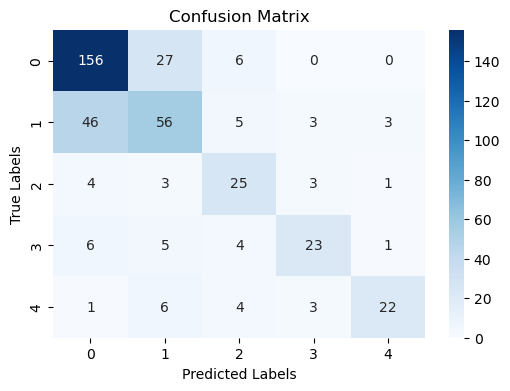

In [15]:
# @title Baseline - Imagens originais

# param_grid = {'n_clusters': [3, 4, 5, 7]}
# seeds = [42, 123, 456]
# classification_clustering_opt(data = df_data,
#                               seeds = seeds,
#                               param_grid = param_grid,
#                               num_representatives = 5,
#                               figsize = (10, 4))

results = []
# param_grid = {
#     'n_neighbors': [3, 5, 7,],
#     'weights': ['uniform', 'distance'],
#     'metric': ['euclidean', 'cosine']
#   }

report_base, _ = classification_KNN_opt(data_imgs = dataset_sample,
                                        labels = sampled_train_df['y'],
                                        param_grid = None,
                                        scoring='f1_macro',
                                        folds=3,
                                        unique_id='Baseline')

results.append(report_base)

In [16]:
# @title Pré-processamento

def preprocess_image(image_path, target_size=(128, 128), normalize=True):
    """
    Preprocess an image by resizing and optionally normalizing pixel values.

    Parameters:
        image_path (str): Path to the image file.
        target_size (tuple): Desired image size (width, height).
        normalize (bool): Whether to normalize pixel values to [0, 1].

    Returns:
        np.array: Preprocessed image.
    """
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image at {image_path} could not be loaded.")

    # Resize image
    resized_image = cv2.resize(image, target_size)

    # Normalize pixel values
    if normalize:
        resized_image = resized_image / 255.0  # Convert range to [0, 1]
        resized_image = (resized_image * 255).astype(np.uint8)  # Convert back to uint8 for OpenCV compatibility

    return resized_image

In [17]:
# @title Ajustes nas cores

def adjust_brightness(image, factor=1.0):
    """
    Adjust brightness of an image.
    Parameters:
        image (np.array): Input image.
        factor (float): Factor by which to adjust brightness (1.0 = no change).
    Returns:
        np.array: Brightness-adjusted image.
    """
    return cv2.convertScaleAbs(image, alpha=factor, beta=0)  # alpha for contrast, beta for brightness

def adjust_contrast(image, factor=1.0):
    """
    Adjust contrast of an image.
    Parameters:
        image (np.array): Input image.
        factor (float): Factor by which to adjust contrast (1.0 = no change).
    Returns:
        np.array: Contrast-adjusted image.
    """
    return cv2.convertScaleAbs(image, alpha=factor, beta=0)

def adjust_saturation(image, factor=1.0):
    """
    Adjust saturation of an image.
    Parameters:
        image (np.array): Input image in BGR format.
        factor (float): Factor by which to adjust saturation (1.0 = no change).
    Returns:
        np.array: Saturation-adjusted image.
    """
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv_image[:, :, 1] = cv2.multiply(hsv_image[:, :, 1], factor)  # Multiply saturation channel
    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)


def adjust_sharpness(image, factor=1.0):
    """
    Adjust the sharpness of an image using an unsharp mask.

    Parameters:
        image (np.array): Input image.
        factor (float): Sharpness multiplier (1.0 = no change, >1.0 increases sharpness, <1.0 softens the image).

    Returns:
        np.array: Image with adjusted sharpness.
    """
    # Create a blurred version of the image
    blurred = cv2.GaussianBlur(image, (9, 9), 10.0)

    # Combine the original and blurred images
    sharpened = cv2.addWeighted(image, 1 + factor, blurred, -factor, 0)
    return sharpened


def adjust_shadows(image, factor=1.0):
    """
    Adjust shadows in an image by manipulating the lower half of the pixel intensity range.

    Parameters:
        image (np.array): Input image.
        factor (float): Shadow adjustment multiplier (1.0 = no change, <1.0 darkens shadows, >1.0 lightens shadows).

    Returns:
        np.array: Image with adjusted shadows.
    """
    # Convert to LAB color space to adjust brightness
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab_image)

    # Apply a gamma correction-like adjustment to the L channel
    l_channel = cv2.multiply(l_channel, factor)
    l_channel = np.clip(l_channel, 0, 255).astype(np.uint8)

    # Merge channels back
    adjusted_lab = cv2.merge((l_channel, a, b))
    return cv2.cvtColor(adjusted_lab, cv2.COLOR_LAB2BGR)


In [18]:
# @title Técnicas de remoção de ruído

def low_pass_filter(image, kernel_size=(5, 5)):
    """
    Apply a low-pass filter (smoothing) to reduce high-frequency noise.
    Parameters:
        image (np.array): Input image.
        kernel_size (tuple): Size of the smoothing kernel.
    Returns:
        np.array: Smoothed image.
    """
    kernel = np.ones(kernel_size, np.float32) / (kernel_size[0] * kernel_size[1])
    return cv2.filter2D(image, -1, kernel)

def convert_to_uniform_color_space(image, color_space="HSV"):
    """
    Convert an image to a uniform color space (e.g., HSV, Lab).
    Parameters:
        image (np.array): Input image.
        color_space (str): Desired color space ("HSV" or "Lab").
    Returns:
        np.array: Image in the specified color space.
    """
    if color_space.upper() == "HSV":
        return cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    elif color_space.upper() == "LAB":
        return cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    else:
        raise ValueError("Unsupported color space. Choose 'HSV' or 'Lab'.")

def adaptive_threshold(image, max_value=255, adaptive_method="gaussian", block_size=11, c=2):
    """
    Apply adaptive thresholding to a grayscale image.
    Parameters:
        image (np.array): Grayscale input image.
        max_value (int): Maximum value for the thresholded output.
        adaptive_method (str): Thresholding method ("gaussian" or "mean").
        block_size (int): Size of the local region to calculate the threshold.
        c (int): Constant subtracted from the threshold.
    Returns:
        np.array: Thresholded binary image.
    """
    if adaptive_method.lower() == "gaussian":
        method = cv2.ADAPTIVE_THRESH_GAUSSIAN_C
    elif adaptive_method.lower() == "mean":
        method = cv2.ADAPTIVE_THRESH_MEAN_C
    else:
        raise ValueError("Unsupported adaptive method. Choose 'gaussian' or 'mean'.")
    
    return cv2.adaptiveThreshold(image, max_value, method, cv2.THRESH_BINARY, block_size, c)


def apply_median_blur(image, kernel_size=5):
    """
    Apply median blur to reduce salt-and-pepper noise.
    Parameters:
        image (np.array): Input image.
        kernel_size (int): Size of the kernel (must be odd).
    Returns:
        np.array: Blurred image.
    """
    return cv2.medianBlur(image, kernel_size)


def apply_gaussian_blur(image, kernel_size=(5, 5)):
    """
    Apply Gaussian blur to an image.
    Parameters:
        image (np.array): Input image.
        kernel_size (tuple): Size of the Gaussian kernel.
    Returns:
        np.array: Blurred image.
    """
    return cv2.GaussianBlur(image, kernel_size, 0)


def apply_bilateral_filter(image, d=9, sigmaColor=75, sigmaSpace=75):
    """
    Apply bilateral filtering to reduce noise while preserving edges.
    Parameters:
        image (np.array): Input image.
        d (int): Diameter of each pixel neighborhood.
        sigmaColor (float): Filter sigma in the color space.
        sigmaSpace (float): Filter sigma in the coordinate space.
    Returns:
        np.array: Filtered image.
    """
    return cv2.bilateralFilter(image, d, sigmaColor, sigmaSpace)


def apply_nlm_denoising(image, h=10, hForColor=10, templateWindowSize=7, searchWindowSize=21):
    """
    Apply Non-Local Means (NLM) denoising.
    Parameters:
        image (np.array): Input image.
        h (float): Filter strength for luminance.
        hForColor (float): Filter strength for color.
        templateWindowSize (int): Size of the template window.
        searchWindowSize (int): Size of the search window.
    Returns:
        np.array: Denoised image.
    """
    return cv2.fastNlMeansDenoisingColored(image, None, h, hForColor, templateWindowSize, searchWindowSize)


# Function to apply Fourier Transform filtering to a single channel
def filter_channel(channel):
    dft = cv2.dft(np.float32(channel), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    fshift = dft_shift * mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv2.idft(f_ishift)
    return cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])
    
def apply_frequency_filter(image):
    """
    Apply frequency domain filtering (low-pass filter) to a color image.
    
    This function applies a low-pass filter in the frequency domain to each color channel 
    of the input image, by performing a Fourier Transform, modifying the frequency spectrum,
    and then applying an inverse Fourier Transform to return the filtered image.
    
    Parameters:
        image (np.array): Input color image (BGR format).
    
    Returns:
        np.array: The filtered color image.
    """
    
    # Check if the image is colored (3 channels) and convert to RGB if needed
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Get the image dimensions
    rows, cols, _ = image.shape
    crow, ccol = rows // 2, cols // 2

    # Create a mask for the low-pass filter
    mask = np.zeros((rows, cols, 2), np.uint8)
    mask[crow-30:crow+30, ccol-30:ccol+30] = 1

    # Split the image into R, G, B channels
    channels = cv2.split(image)
    filtered_channels = [filter_channel(ch) for ch in channels]

    # Normalize and combine the filtered channels back
    filtered_channels = [cv2.normalize(ch, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8) for ch in filtered_channels]
    filtered_image = cv2.merge(filtered_channels)

    return filtered_image

In [19]:
# @title Técnicas de detecção de bordas -> melhorar, talvez retornar segmentada

def to_grayscale(image):
    """
    Convert an image to grayscale.
    Parameters:
        image (np.array): Input image.
    Returns:
        np.array: Grayscale image.
    """
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def detect_edges(image, low_threshold=50, high_threshold=150):
    """
    Detect edges in an image using the Canny edge detection method.
    Parameters:
        image (np.array): Input image (grayscale recommended).
        low_threshold (int): Low threshold for edge detection.
        high_threshold (int): High threshold for edge detection.
    Returns:
        np.array: Edge-detected image.
    """
    return cv2.Canny(image, low_threshold, high_threshold)

In [20]:
import matplotlib.pyplot as plt
import cv2

def process_and_plot_image(image_path):
    """
    Process the image by adjusting brightness, contrast, saturation, sharpness, and shadows,
    applying denoising, converting to grayscale, and detecting edges. Then, plots the results.
    
    Parameters:
        image_path (str): Path to the input image.
    """
    # Load and preprocess the image
    preprocessed_image = preprocess_image(image_path, target_size=(256, 256))

    # Adjust brightness and contrast
    bright_image = adjust_brightness(preprocessed_image, factor=.8)  # Slightly increase brightness
    contrast_image = adjust_contrast(bright_image, factor=1.2)

    # Adjust saturation
    saturation_adjusted = adjust_saturation(contrast_image, factor=2)

    # Adjust sharpness
    sharpness_adjusted = adjust_sharpness(saturation_adjusted, factor=1.2)

    # Adjust shadows
    shadows_adjusted = adjust_shadows(sharpness_adjusted, factor=1.2)

    # Apply Non-Local Means Denoising
    denoised = apply_nlm_denoising(shadows_adjusted, h=10, hForColor=10, templateWindowSize=7, searchWindowSize=21)

    # Convert to grayscale and detect edges
    grayscale_image = to_grayscale(shadows_adjusted)
    edges = detect_edges(grayscale_image, low_threshold=100, high_threshold=250)

    # Display the results
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 4, 1); plt.imshow(preprocessed_image); plt.title("Original")
    plt.subplot(2, 4, 2); plt.imshow(bright_image); plt.title("Brightness Adjusted")
    plt.subplot(2, 4, 3); plt.imshow(contrast_image); plt.title("Contrast Adjusted")
    plt.subplot(2, 4, 4); plt.imshow(saturation_adjusted); plt.title("Saturation Adjusted")
    plt.subplot(2, 4, 5); plt.imshow(sharpness_adjusted); plt.title("Sharpness Adjusted")
    plt.subplot(2, 4, 6); plt.imshow(shadows_adjusted); plt.title("Shadows Adjusted")
    plt.subplot(2, 4, 7); plt.imshow(denoised); plt.title("Denoised Image")
    plt.subplot(2, 4, 8); plt.imshow(edges, cmap="gray"); plt.title("Edges Detected")
    plt.tight_layout()
    plt.show()

In [21]:
import matplotlib.pyplot as plt
import cv2

def denoise_and_plot(image_path, kernel = 5):
    """
    Apply various denoising techniques and preprocessing steps to an image, and plot the results.
    
    Parameters:
        image_path (str): Path to the input image.
    """
    # Load the image
    image = preprocess_image(image_path, target_size=(256, 256))

    # Denoising techniques
    gaussian_image = apply_gaussian_blur(image, kernel_size=(kernel, kernel))
    median_image = apply_median_blur(image, kernel_size=kernel)
    bilateral_image = apply_bilateral_filter(image, d=9, sigmaColor=75, sigmaSpace=75)

    # Preprocessing steps
    low_passed_image = low_pass_filter(image, kernel_size=(kernel, kernel))
    hsv_image = convert_to_uniform_color_space(image, color_space="HSV")
    lab_image = convert_to_uniform_color_space(image, color_space="LAB")

    # Convert to grayscale for adaptive thresholding
    grayscale_image = to_grayscale(image)
    adaptive_thresh_image = adaptive_threshold(grayscale_image, max_value=255, 
                                               adaptive_method="gaussian", block_size=11, c=2)

    # Display the results
    plt.figure(figsize=(12, 6))
    
    # Original image
    plt.subplot(2, 4, 1); plt.imshow(image); plt.title("Original")
    
    # Denoising techniques
    plt.subplot(2, 4, 2); plt.imshow(gaussian_image); plt.title("Gaussian Blur")
    plt.subplot(2, 4, 3); plt.imshow(median_image); plt.title("Median Blur")
    plt.subplot(2, 4, 4); plt.imshow(bilateral_image); plt.title("Bilateral Filter")
    
    # Preprocessing steps
    plt.subplot(2, 4, 5); plt.imshow(low_passed_image); plt.title("Low Pass Filter")
    plt.subplot(2, 4, 6); plt.imshow(hsv_image); plt.title("HSV Color Space")
    plt.subplot(2, 4, 7); plt.imshow(lab_image); plt.title("LAB Color Space")
    
    # Adaptive thresholding result
    plt.subplot(2, 4, 8); plt.imshow(adaptive_thresh_image, cmap="gray"); plt.title("Adaptive Threshold")
    
    plt.tight_layout()
    plt.show()



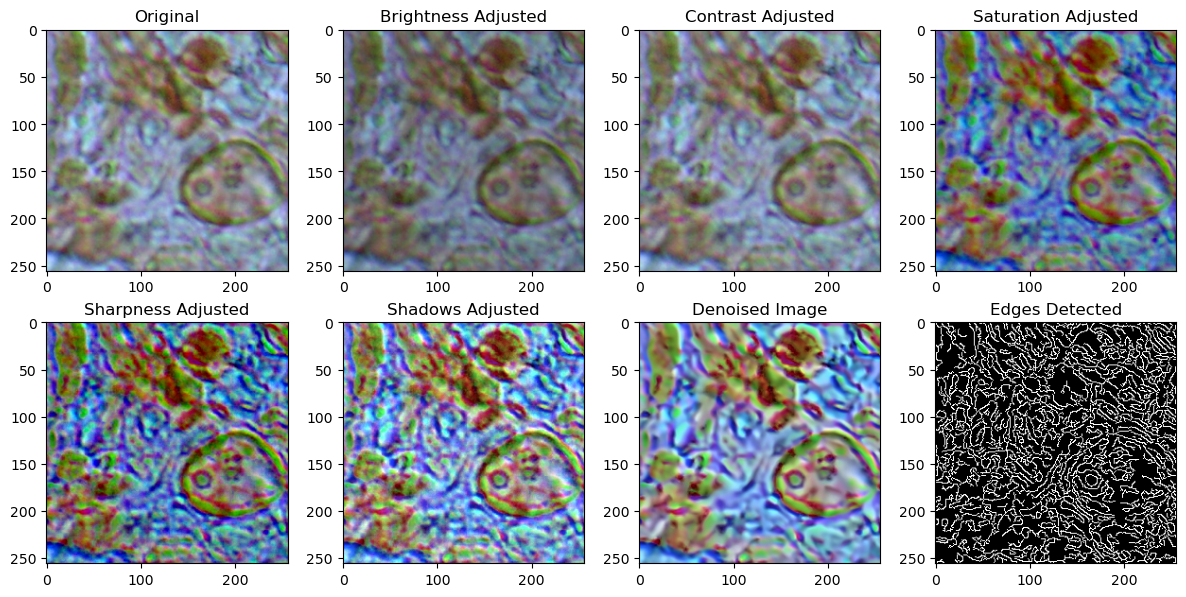

In [22]:
image_path = "content/H5/H5_20a_4.jpg"
process_and_plot_image(image_path)

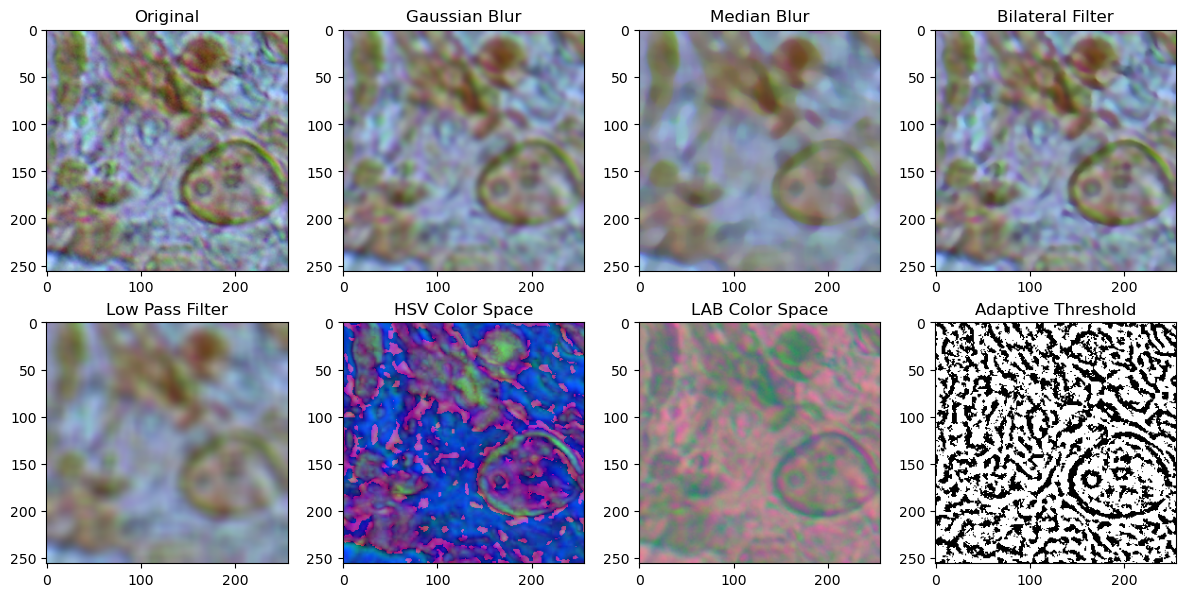

In [23]:
# @title -> AQUI PRECISA IMPLEMENTAR GRID SEARCH -> ESCOLHER 3 OU 4 TECNICAS?
denoise_and_plot(image_path, kernel = 15)

In [24]:
def process_image_pipeline(
    image_path,
    target_size=(256, 256),
    brightness_factor=0.8,
    contrast_factor=1.2,
    saturation_factor=2.0,
    sharpness_factor=1.2,
    shadows_factor=1.1,
):
    """
    Process an image through a pipeline of adjustments and edge detection.

    Parameters:
        image_path (str): Path to the input image.
        target_size (tuple): Desired size for resizing (width, height).
        brightness_factor (float): Brightness adjustment factor.
        contrast_factor (float): Contrast adjustment factor.
        saturation_factor (float): Saturation adjustment factor.
        sharpness_factor (float): Sharpness adjustment factor.
        shadows_factor (float): Shadows adjustment factor.

    Returns:
        tuple: Processed images at different stages of the pipeline:
               (original, adjusted, grayscale, edges).
    """
    # Preprocess the image
    preprocessed_image = preprocess_image(image_path, target_size=target_size)

    # Adjust brightness and contrast
    bright_image = adjust_brightness(preprocessed_image, factor=brightness_factor)
    contrast_image = adjust_contrast(bright_image, factor=contrast_factor)

    # Adjust saturation
    saturation_adjusted = adjust_saturation(contrast_image, factor=saturation_factor)

    # Adjust sharpness
    sharpness_adjusted = adjust_sharpness(saturation_adjusted, factor=sharpness_factor)

    # Adjust shadows
    shadows_adjusted = adjust_shadows(sharpness_adjusted, factor=shadows_factor)

    return saturation_adjusted, shadows_adjusted

In [25]:
import pandas as pd
import os
import cv2

def process_dataset(data, tag,
    brightness_factor=0.8,
    contrast_factor=1.2,
    saturation_factor=2.0,
    sharpness_factor=1.2,
    shadows_factor=1.1,):

    # Dictionary to store processed images in memory
    processed_images = {
        "saturation": [],
        "shadows": [],
    }

    # Iterate through DataFrame paths and process each image
    for idx, row in data.iterrows():
        image_path = row['path']
        image_name = os.path.basename(image_path)

        try:
            # Process the image through the pipeline
            saturation, shadows = process_image_pipeline(
                image_path,
                target_size=(256, 256),
                brightness_factor=brightness_factor,
                contrast_factor=contrast_factor,
                saturation_factor=saturation_factor,
                sharpness_factor=sharpness_factor,
                shadows_factor=shadows_factor,
            )

            # Store the processed images in memory (no saving to disk)
            processed_images["saturation"].append(saturation)
            processed_images["shadows"].append(shadows)

        except Exception as e:
            print(f"Failed to process {image_path}: {e}")
    
    report_saturation, _ = classification_KNN_opt(data_imgs=processed_images["saturation"],
                                                 labels = data['y'],
                                                 param_grid=None,
                                                 scoring='f1_macro',
                                                 folds=3,
                                                 unique_id=tag + '_saturation',
                                                 show_results=False)


    report_shadows, _ = classification_KNN_opt(data_imgs=processed_images["shadows"],
                                              labels = data['y'],
                                              param_grid=None,
                                              scoring='f1_macro',
                                              folds=3,
                                              unique_id=tag + '_shadows',
                                              show_results=False)

    # Combine and return the classification reports
    return pd.concat([report_saturation, report_shadows], axis=0)

In [26]:
import itertools

# Hyperparameter values
brightness_factor_values = [0.8, 1.0, 1.2, 1.5, 1.7]
contrast_factor_values = [0.6, 0.8, 1.0, 1.2]
saturation_factor_values = [0.8, 1.0, 1.2,]
sharpness_factor_values = [0.6, 0.8, 1.0, 1.2]
shadows_factor_values = [0.8, 1.0, 1.3, 1.5, 1.7]

# Teste funcionamento rapido
# brightness_factor_values = [1.5, 1.7]
# contrast_factor_values = [0.6, 0.8]
# saturation_factor_values = [1.0, 1.2,]
# sharpness_factor_values = [0.6, 0.8,]
# shadows_factor_values = [1.3, 1.5, 1.7]

# Generate all combinations of the hyperparameters
param_combinations = list(itertools.product(
    brightness_factor_values,
    contrast_factor_values,
    saturation_factor_values,
    sharpness_factor_values,
    shadows_factor_values,
))

len(param_combinations)

1200

In [27]:
from tqdm import tqdm  # Import tqdm for progress bar

exp_id = []
exp_results = []

for idx, params in tqdm(enumerate(param_combinations, 1), total=len(param_combinations), desc="Experiments", unit="exp"):
    brightness, contrast, saturation, sharpness, shadows = params
    
    aux_result = process_dataset(
            data=sampled_train_df,
            tag=str(idx),
            brightness_factor=params[0],
            contrast_factor=params[1],
            saturation_factor=params[2],
            sharpness_factor=params[3],
            shadows_factor=params[4],
        )

    aux_result["brightness_factor"] = brightness
    aux_result["contrast_factor"] = contrast
    aux_result["saturation_factor"] = saturation
    aux_result["sharpness_factor"] = sharpness
    aux_result["shadows_factor"] = shadows

    exp_results.append(aux_result)

Experiments: 100%|██████████| 1200/1200 [2:19:34<00:00,  6.98s/exp] 


In [28]:
# @title TALVEZ AGRUPAR MELHOR OS CASOS? (Brightness + Contrast) & (Saturation + Shadows) & (Sharpness)??? AO INVES DE SATURATION & SHADOWNS
results_compiled = pd.concat(exp_results, axis = 0)
results_compiled.head(16)

,precision,recall,f1-score,support,id,brightness_factor,contrast_factor,saturation_factor,sharpness_factor,shadows_factor
0,0.744186,0.846561,0.792079,189.000000,1_saturation,0.8,0.6,0.8,0.6,0.8
1,0.606383,0.504425,0.550725,113.000000,1_saturation,0.8,0.6,0.8,0.6,0.8
2,0.571429,0.666667,0.615385,36.000000,1_saturation,0.8,0.6,0.8,0.6,0.8
3,0.758621,0.564103,0.647059,39.000000,1_saturation,0.8,0.6,0.8,0.6,0.8
4,0.787879,0.722222,0.753623,36.000000,1_saturation,0.8,0.6,0.8,0.6,0.8
accuracy,0.699758,0.699758,0.699758,0.699758,1_saturation,0.8,0.6,0.8,0.6,0.8
macro avg,0.693699,0.660795,0.671774,413.000000,1_saturation,0.8,0.6,0.8,0.6,0.8
weighted avg,0.696595,0.699758,0.693594,413.000000,1_saturation,0.8,0.6,0.8,0.6,0.8
0,0.754630,0.862434,0.804938,189.000000,1_shadows,0.8,0.6,0.8,0.6,0.8
1,0.652174,0.530973,0.585366,113.000000,1_shadows,0.8,0.6,0.8,0.6,0.8


In [29]:
acc_results = results_compiled.reset_index()
acc_results = acc_results.sort_values(by='index')
acc_results.head()

,index,precision,recall,f1-score,support,id,brightness_factor,contrast_factor,saturation_factor,sharpness_factor,shadows_factor
0,0,0.744186,0.846561,0.792079,189.0,1_saturation,0.8,0.6,0.8,0.6,0.8
9688,0,0.733945,0.846561,0.786241,189.0,606_shadows,1.2,1.0,0.8,0.8,0.8
9680,0,0.747619,0.830688,0.786967,189.0,606_saturation,1.2,1.0,0.8,0.8,0.8
18896,0,0.689956,0.835979,0.755981,189.0,1182_saturation,1.7,1.2,1.2,0.6,1.0
2416,0,0.740741,0.846561,0.790123,189.0,152_saturation,0.8,1.0,1.0,1.0,1.0


<Axes: xlabel='index', ylabel='f1-score'>

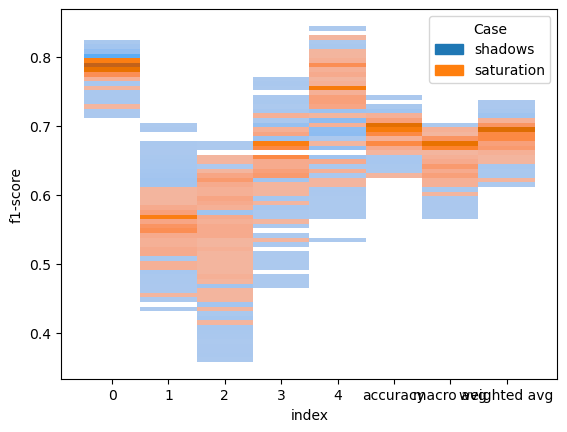

In [36]:
sns.histplot(data = acc_results, x = 'index', y = 'f1-score', hue = 'Case', hue_order = ['shadows', 'saturation'])

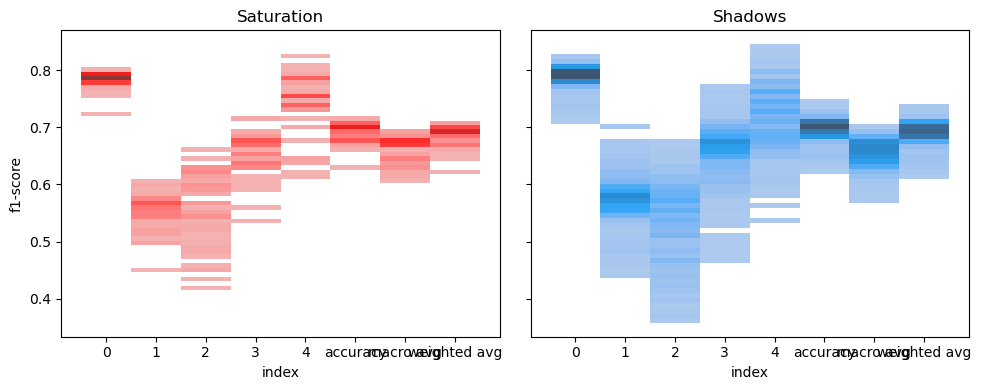

In [40]:
acc_results[['Exp', 'Case']] = acc_results['id'].str.split('_', expand = True)

# Create a figure and two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

# Plot the first histogram for 'saturation'
sns.histplot(
    data=acc_results[acc_results['Case'] == 'saturation'], 
    x='index', 
    y='f1-score', 
    color = 'red',
    ax=axes[0]
)
axes[0].set_title('Saturation')

# Plot the second histogram for 'shadows'
sns.histplot(
    data=acc_results[acc_results['Case'] == 'shadows'], 
    x='index', 
    y='f1-score', 
    ax=axes[1]
)
axes[1].set_title('Shadows')

# Adjust layout
plt.tight_layout()
plt.show()

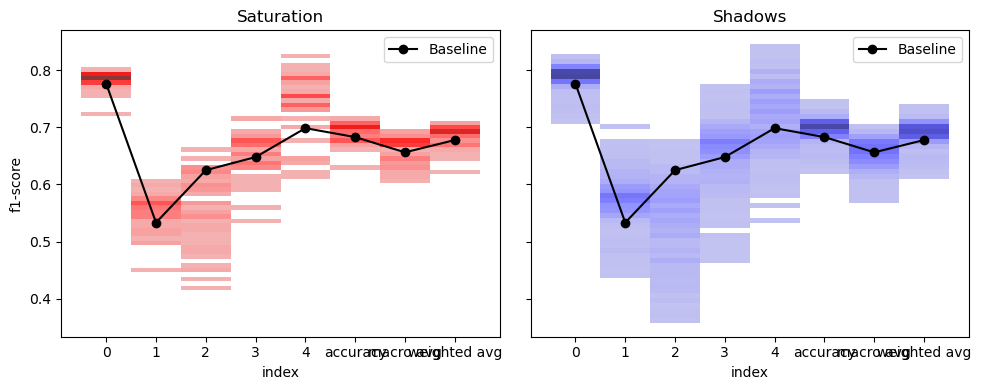

In [50]:
def plot_case_comparison(data, baseline_data, metric, figsize=(12, 4), colors=('red', 'blue')):
    """
    Plots histograms of a specified metric for two cases side by side and overlays baseline data as individual lines.

    Parameters:
    - data: DataFrame containing the case-specific data. Must include 'Case', 'index', and the metric column.
    - baseline_data: DataFrame containing baseline metrics. Must include 'index' and the metric column.
    - metric: str, the name of the column to use for the y-axis.
    - figsize: tuple, optional. The size of the figure.
    - colors: tuple, optional. Colors for the two histograms.
    """
    # Extract baseline x and y values
    baseline_x = baseline_data['index']
    baseline_y = baseline_data[metric]
    
    # Create a figure and two subplots
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharex=True, sharey=True)

    # Plot the first histogram for 'saturation'
    sns.histplot(
        data=data[data['Case'] == 'saturation'], 
        x='index', 
        y=metric, 
        color=colors[0], 
        ax=axes[0]
    )
    axes[0].set_title('Saturation')
    axes[0].plot(baseline_x, baseline_y, color='black', marker='o', label='Baseline')
    axes[0].legend()

    # Plot the second histogram for 'shadows'
    sns.histplot(
        data=data[data['Case'] == 'shadows'], 
        x='index', 
        y=metric, 
        color=colors[1], 
        ax=axes[1]
    )
    axes[1].set_title('Shadows')
    axes[1].plot(baseline_x, baseline_y, color='black', marker='o', label='Baseline')
    axes[1].legend()

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

plot_case_comparison(data = acc_results, baseline_data = results[0].reset_index(), metric = 'f1-score', figsize=(10, 4), colors=('red', 'blue'))

In [53]:
acc_results[acc_results['index'] == 'accuracy'].sort_values(by='f1-score')

,index,precision,recall,f1-score,support,id,brightness_factor,contrast_factor,saturation_factor,sharpness_factor,shadows_factor,Exp,Case
18253,accuracy,0.627119,0.627119,0.627119,0.627119,1141_shadows,1.7,1.2,0.8,0.6,0.8,1141,shadows
18757,accuracy,0.629540,0.629540,0.629540,0.629540,1173_saturation,1.7,1.2,1.0,1.0,1.3,1173,saturation
18693,accuracy,0.629540,0.629540,0.629540,0.629540,1169_saturation,1.7,1.2,1.0,0.8,1.5,1169,saturation
18597,accuracy,0.629540,0.629540,0.629540,0.629540,1163_saturation,1.7,1.2,1.0,0.6,1.3,1163,saturation
18645,accuracy,0.629540,0.629540,0.629540,0.629540,1166_saturation,1.7,1.2,1.0,0.8,0.8,1166,saturation
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4093,accuracy,0.731235,0.731235,0.731235,0.731235,256_shadows,1.0,0.6,0.8,1.2,0.8,256,shadows
7181,accuracy,0.738499,0.738499,0.738499,0.738499,449_shadows,1.0,1.2,1.0,0.8,1.5,449,shadows
10061,accuracy,0.738499,0.738499,0.738499,0.738499,629_shadows,1.2,1.0,1.0,0.8,1.5,629,shadows
7101,accuracy,0.740920,0.740920,0.740920,0.740920,444_shadows,1.0,1.2,1.0,0.6,1.5,444,shadows


# @title Comparação DeepLearning Kaggle:

acc : 0.766    https://www.kaggle.com/code/jonadi/inceptionv3-fungi-images-classification

acc : 0.850    https://www.kaggle.com/code/banddaniel/fungus-detect-w-10cv-custom-convmixer-f1-0-85

acc : 0.925    https://www.kaggle.com/code/chihjungwang/microscopic-fungi-pytorch-acc-92

acc : 0.936    https://www.kaggle.com/code/balkarjun/fungi-image-classification-using-fastai-93-acc

In [77]:
from sklearn.ensemble import RandomForestClassifier


def classification_KNN_opt_splited(treino_imgs, treino_labels, 
                           teste_imgs, teste_labels, 
                           param_grid, scoring='f1_macro', folds=3, unique_id=None, show_results = True):

    X_train = compute_low_level_features(treino_imgs) 
    y_train = treino_labels

    X_test = compute_low_level_features(teste_imgs) 
    y_test = teste_labels

    
    # Initialize the Random Forest classifier
    knn_cl = LogisticRegression(C=1.0, solver='lbfgs', max_iter=1000)
    # RandomForestClassifier(
    #     n_estimators=300,      # Number of trees
    #     max_depth=None,        # Maximum depth of each tree
    #     min_samples_split=2,   # Minimum samples required to split a node
    #     min_samples_leaf=1,    # Minimum samples required at a leaf node
    #     bootstrap=True,        # Whether to use bootstrapping
    #     random_state=42        # Ensures reproducibility
    # )

    knn_cl.fit(X_train, y_train)
    y_pred = knn_cl.predict(X_test)
    
    if show_results:
      print('Classification test w/ KNN baseline:')
      print(classification_report(y_test, y_pred, zero_division=0))

    if isinstance(param_grid, dict):
        # Grid search
        grid_search = GridSearchCV(knn_cl, param_grid,
                                   scoring=scoring,
                                   cv=folds,
                                   n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Check for warnings or NaN scores
        if np.isnan(grid_search.cv_results_['mean_test_score']).any():
            print("Warning: Some grid search results contain NaN values.")

        # Final prediction and evaluation
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        if show_results:
          # Best parameters
          print("Best parameters:", grid_search.best_params_)
          print(classification_report(y_test, y_pred, zero_division=0))
          print("Confusion Matrix:")

          # Plotting Confusion Matrix
          plt.figure(figsize=(6, 4))
          sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
          plt.title("Confusion Matrix")
          plt.xlabel("Predicted Labels")
          plt.ylabel("True Labels")
          plt.show()

    else:
        # # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        if show_results:
          print("Confusion Matrix:")

          # Plotting Confusion Matrix
          plt.figure(figsize=(6, 4))
          sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
          plt.title("Confusion Matrix")
          plt.xlabel("Predicted Labels")
          plt.ylabel("True Labels")
          plt.show()

        best_model = None

    # Generate the classification report as a DataFrame
    report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    # Add the unique ID to the dataframe
    report_df['id'] = unique_id

    return report_df, best_model

In [75]:
def process_images_datafet(data,
    brightness_factor=1.2,
    contrast_factor=1.0,
    saturation_factor=1.0,
    sharpness_factor=0.6,
    shadows_factor=1.5,):

    # Dictionary to store processed images in memory
    processed_images = []
    # Iterate through DataFrame paths and process each image
    for idx, row in data.iterrows():
        image_path = row['path']
        image_name = os.path.basename(image_path)

        try:
            # Process the image through the pipeline
            _, shadows = process_image_pipeline(
                image_path,
                target_size=(256, 256),
                brightness_factor=brightness_factor,
                contrast_factor=contrast_factor,
                saturation_factor=saturation_factor,
                sharpness_factor=sharpness_factor,
                shadows_factor=shadows_factor,
            )

            # Store the processed images in memory (no saving to disk)
            processed_images.append(shadows)

        except Exception as e:
            print(f"Failed to process {image_path}: {e}")
    

    # Combine and return the classification reports
    return processed_images

In [63]:
train_df_processed = process_images_datafet(data = train_df)
test_df_processed = process_images_datafet(data = test_df)

In [66]:
train_df_imgs = process_images_datafet(data = train_df, brightness_factor=1.,contrast_factor=1.0,saturation_factor=1.0,sharpness_factor=1,shadows_factor=1,)
test_df_imgs = process_images_datafet(data = test_df, brightness_factor=1.,contrast_factor=1.0,saturation_factor=1.0,sharpness_factor=1,shadows_factor=1,)

In [78]:
_, _ = classification_KNN_opt_splited(treino_imgs = train_df_imgs, treino_labels = train_df['y'], 
                           teste_imgs = test_df_imgs, teste_labels = test_df['y'],
                           param_grid = None, scoring='f1_macro', folds=3, unique_id=None, show_results = True)

NameError: name 'LogisticRegression' is not defined

Classification test w/ KNN baseline:
              precision    recall  f1-score   support

           0       0.66      0.94      0.77       881
           1       0.53      0.26      0.35       467
           2       0.93      0.26      0.41       164
           3       0.81      0.55      0.65       163
           4       0.75      0.89      0.81       148

    accuracy                           0.67      1823
   macro avg       0.74      0.58      0.60      1823
weighted avg       0.67      0.67      0.62      1823

Confusion Matrix:


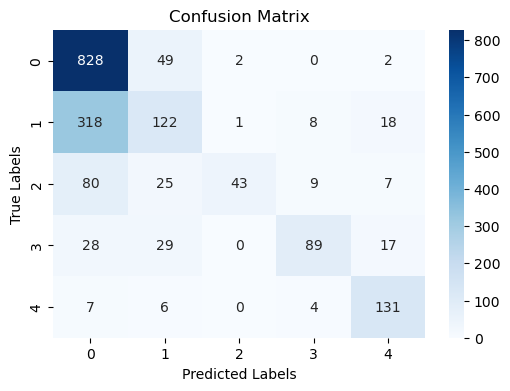

(              precision    recall  f1-score      support    id
 0              0.656622  0.939841  0.773109   881.000000  None
 1              0.528139  0.261242  0.349570   467.000000  None
 2              0.934783  0.262195  0.409524   164.000000  None
 3              0.809091  0.546012  0.652015   163.000000  None
 4              0.748571  0.885135  0.811146   148.000000  None
 accuracy       0.665387  0.665387  0.665387     0.665387  None
 macro avg      0.735441  0.578885  0.599073  1823.000000  None
 weighted avg   0.669829  0.665387  0.624163  1823.000000  None,
 None)

In [71]:
classification_KNN_opt_splited(treino_imgs = train_df_processed, treino_labels = train_df['y'], 
                           teste_imgs = test_df_processed, teste_labels = test_df['y'],
                           param_grid = None, scoring='f1_macro', folds=3, unique_id=None, show_results = True)

Classification test w/ KNN baseline:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       881
           1       0.79      0.74      0.76       467
           2       0.84      0.72      0.77       164
           3       0.89      0.84      0.86       163
           4       0.96      0.94      0.95       148

    accuracy                           0.85      1823
   macro avg       0.87      0.83      0.85      1823
weighted avg       0.85      0.85      0.85      1823

Best parameters: {'metric': 'cosine', 'n_neighbors': 3, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       881
           1       0.79      0.74      0.76       467
           2       0.84      0.72      0.77       164
           3       0.89      0.84      0.86       163
           4       0.96      0.94      0.95       148

    accuracy                           0.85      1823
   macro avg   

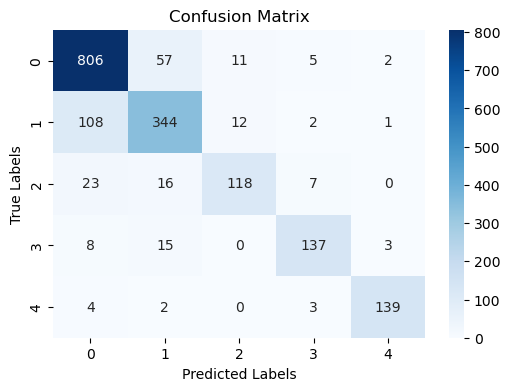

In [68]:
param_grid = {
    'n_neighbors': [3, 5, 7,],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'cosine']
  }

_, _ = classification_KNN_opt_splited(treino_imgs = train_df_processed, treino_labels = train_df['y'], 
                           teste_imgs = test_df_processed, teste_labels = test_df['y'],
                           param_grid = param_grid, scoring='f1_macro', folds=3, unique_id=None, show_results = True)

In [31]:
# TODO IMPACTO DENOISING